In [1]:
import sys
import datacube
import numpy as np
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

sys.path.append('../../Tools')
from dea_tools.datahandling import load_ard
from dea_tools.datahandling import mostcommon_crs

from dea_tools.plotting import xr_animation
from dea_tools.coastal import tidal_tag
from skimage.color import rgb2hsv, hsv2rgb

def hue_sat_val(rgb_array,
                hue_mult=1, 
                sat_mult=0.8, 
                val_mult=1):   
    
    # Convert to HSV and multiply bands
    hsv_array = rgb2hsv(rgb_array)
    hsv_array[:, :, 0] = hsv_array[:, :, 0] * hue_mult
    hsv_array[:, :, 1] = hsv_array[:, :, 1] * sat_mult
    hsv_array[:, :, 2] = hsv_array[:, :, 2] * val_mult
    
    # Convert back to RGB
    return hsv2rgb(hsv_array.clip(0, 1))


dc = datacube.Datacube(app='Animated timeseries' )

%load_ext autoreload
%autoreload 2

In [2]:
# Configure local dask cluster
from dea_tools.dask import create_local_dask_cluster
create_local_dask_cluster()

# # Create dask gateway cluser
# from dea_tools.dask import create_dask_gateway_cluster
# cluster = create_dask_gateway_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34631,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:43603,Total threads: 15
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/44759/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:40777,


In [3]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geopolygon = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4) 

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [8]:
# Input params
bands=['nbart_red', 'nbart_green', 'nbart_blue']
# bands=['nbart_swir_1', 'nbart_nir', 'nbart_green', 'nbart_red']
time = ('1988', '2023')

# Landsat, native res
crs = mostcommon_crs(dc=dc, 
                     product='ga_ls5t_ard_3', 
                     query={'time': '1990', 
                            'geopolygon': geopolygon})

# query = {
#     'geopolygon': geopolygon,
#     'time': time,
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest', 
#                    'oa_fmask': 'nearest', 
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-30, 30),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000}
# }

# Landsat upscaled res
crs = mostcommon_crs(dc=dc, 
                     product='ga_ls5t_ard_3', 
                     query={'time': '1990', 
                            'geopolygon': geopolygon})

query = {
    'geopolygon': geopolygon,
    'time': time,
    'measurements': bands,
    'resampling': {'fmask': 'nearest', 
                   'oa_fmask': 'nearest', 
                   '*': 'cubic'},
    'output_crs': crs,
    'resolution': (-10, 10),
    'group_by': 'solar_day',
    'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000}
}

# # Sentinel-2 10m res
# crs = mostcommon_crs(dc=dc, 
#                      product='s2a_ard_granule', 
#                      query={'time': '2018', 
#                             'geopolygon': geopolygon})

# query = {
#     'geopolygon': geopolygon,
#     'time': time,
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest', 
#                    'oa_fmask': 'nearest', 
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-10, 10),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000}
# }

In [28]:
# Load data
ds = load_ard(
    dc=dc,
    products=[
        "ga_ls5t_ard_3",
        "ga_ls7e_ard_3",
        "ga_ls8c_ard_3",
        "ga_ls9c_ard_3",
        "ga_s2am_ard_3",
        "ga_s2bm_ard_3",
    ],
    min_gooddata=0.9,
    ls7_slc_off=False,
    mask_pixel_quality=False,
    **query
)

# Optionally apply tide filtering
# ds = tidal_tag(ds)
# ds = ds.sel(time = ds.tide_height < ds.tide_height.median())

# Load using dask
ds = ds.compute()
ds

/home/jovyan/Robbi/dea-notebooks/Testing/Animations/../../Tools/dea_tools/datahandling.py:277: UserWarning: You have selected a combination of Landsat and Sentinel-2 products. This can produce unexpected results as these products use the same names for different spectral bands (e.g. Landsat and Sentinel-2's 'nbart_swir_2'); use with caution.
  warnings.warn(


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
    ga_ls9c_ard_3
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 606 out of 1128 time steps with at least 90.0% good quality pixels
Returning 606 time steps as a dask array


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-09-21 04:51:58,186 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-09-21 04:52:05,326 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-09-21 04:52:13,869 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:      (time: 606, y: 386, x: 809)
Coordinates:
  * time         (time) datetime64[ns] 1988-04-13T23:17:35.654726 ... 2023-09...
  * y            (y) float64 -2.734e+06 -2.734e+06 ... -2.738e+06 -2.738e+06
  * x            (x) float64 4.3e+05 4.3e+05 4.3e+05 ... 4.38e+05 4.381e+05
    spatial_ref  int32 32656
Data variables:
    nbart_red    (time, y, x) int16 238 229 229 239 248 ... 403 403 378 345 397
    nbart_green  (time, y, x) int16 515 515 521 534 547 ... 540 537 516 482 513
    nbart_blue   (time, y, x) int16 476 471 470 473 475 ... 367 343 350 343 362
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref

In [17]:
ds = ds.where(ds > 0)

In [18]:
mean_blue = ds.nbart_blue.mean(dim=['x', 'y'])

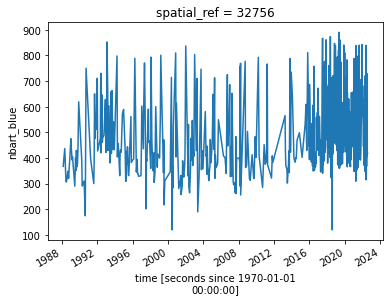

In [37]:
mean_blue.sel(time=mean_blue < 900).plot()

## Pansharpening experiment

In [79]:
# # Load data
# ds_ls57 = load_ard(
#     dc=dc,
#     products=[
#         "ga_ls5t_ard_3",
#         "ga_ls7e_ard_3",
#     ],
#     min_gooddata=0.6,
#     ls7_slc_off=False,
#     mask_pixel_quality=False,
#     **query
# )

# ds_ls57 = ds_ls57.compute()

In [80]:
# query = {
#     'geopolygon': geopolygon,
#     'time': time,
#     'measurements': ['nbar_red', 'nbar_green', 'nbar_blue', 'nbar_panchromatic'],
#     'resampling': {'fmask': 'nearest', 
#                    'oa_fmask': 'nearest', 
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-15, 15),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000}
# }

# # Load data
# ds_ls8 = load_ard(
#     dc=dc,
#     products=[
#         "ga_ls8c_ard_3",
#     ],
#     min_gooddata=0.6,
#     ls7_slc_off=False,
#     mask_pixel_quality=False,
# #     mask_contiguity='nbart_contiguity',
#     **query
# )

# ds_ls8 = ds_ls8.compute()

In [81]:
# ds_ls57_pan = ds_ls57.copy()

In [82]:
# from dea_tools.datahandling import pan_sharpen_brovey
# red_sharpen, green_sharpen, blue_sharpen = pan_sharpen_brovey(
#             band_1=ds_ls57_pan.nbart_red,
#             band_2=ds_ls57_pan.nbart_green,
#             band_3=ds_ls57_pan.nbart_blue,
#             pan_band=ds_ls8.nbart_panchromatic.median(dim='time'))

# ds_ls57_pan['nbart_red'].values = red_sharpen
# ds_ls57_pan['nbart_green'].values = green_sharpen
# ds_ls57_pan['nbart_blue'].values = blue_sharpen

In [83]:
# ds_ls57_pan[['nbart_red', 'nbart_green','nbart_blue']].isel(time=5).to_array().plot.imshow(robust=True, size=10)

In [84]:
# ds_ls57[['nbart_red', 'nbart_green','nbart_blue']].isel(time=5).to_array().plot.imshow(robust=True, size=10)

In [85]:
# brightness = ds_ls57.to_array().sum(dim='variable')
# is_bright = brightness > 2500

In [86]:
# test = ds_ls57.where(is_bright, ds_ls57_pan)

In [87]:
# test[['nbart_red', 'nbart_green','nbart_blue']].isel(time=-5).to_array().plot.imshow(robust=True, size=10)

In [88]:
# ds_ls57.to_array().plot(bins=50)

In [89]:
# ds_ls57_pan.to_array().plot(bins=50)

In [90]:
# from dea_tools.datahandling import pan_sharpen_brovey
# red_sharpen, green_sharpen, blue_sharpen = pan_sharpen_brovey(
#             band_1=ds_ls8.nbar_red,
#             band_2=ds_ls8.nbar_green,
#             band_3=ds_ls8.nbar_blue,
#             pan_band=ds_ls8.nbar_panchromatic)

In [91]:
# ds_ls8['nbar_red'].values = red_sharpen
# ds_ls8['nbar_green'].values = green_sharpen
# ds_ls8['nbar_blue'].values = blue_sharpen

In [92]:
# import xarray as xr
# ds = xr.concat([ds_ls57, ds_ls8], dim='time').sortby('time')

### Apply rolling median to smooth out noise and focus on change
Also calculates median surface reflectance over entire time series as an input to `match_histograms` which will reduce scene-to-scene variability

In [29]:
# Apply rolling median (or optionally, annual resampling)
# ds_rolling = ds.sel(time = mean_blue < 700).sel(time=slice('2015', '2022')).rolling(time=13, center=True, min_periods=1).median()
ds_rolling = ds.resample(time='Y').median(dim='time').rolling(time=3, center=True, min_periods=1).median()

# ds_rolling = ds.rolling(time=30, center=True, min_periods=1).median()

# Calculate all of time median
median_array = np.transpose(ds_rolling[bands]
                            .median(dim='time')
                            .to_array().values, 
                            axes=(1, 2, 0))
print(ds_rolling)
# ds_rolling = ds

<xarray.Dataset>
Dimensions:      (y: 386, x: 809, time: 36)
Coordinates:
  * y            (y) float64 -2.734e+06 -2.734e+06 ... -2.738e+06 -2.738e+06
  * x            (x) float64 4.3e+05 4.3e+05 4.3e+05 ... 4.38e+05 4.381e+05
  * time         (time) datetime64[ns] 1988-12-31 1989-12-31 ... 2023-12-31
    spatial_ref  int32 32656
Data variables:
    nbart_red    (time, y, x) float64 314.0 309.5 307.0 ... 348.0 338.0 353.0
    nbart_green  (time, y, x) float64 611.0 610.0 607.5 ... 495.5 472.5 481.5
    nbart_blue   (time, y, x) float64 528.5 523.5 522.5 ... 311.0 301.5 306.5
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref


## Run animation
`funcs_list` provides a series of image processing functions that are applied to each satellite frame. 
The default values are only examples - each animation will probably require fine tuning (or may not require all techniques at all).

Applying custom image processing functions


  0%|          | 0/377 (0.0 seconds remaining at ? frames/s)

Exporting animation to animation_timeseries_porthacking_s2.mp4


  0%|          | 0/377 (0.0 seconds remaining at ? frames/s)

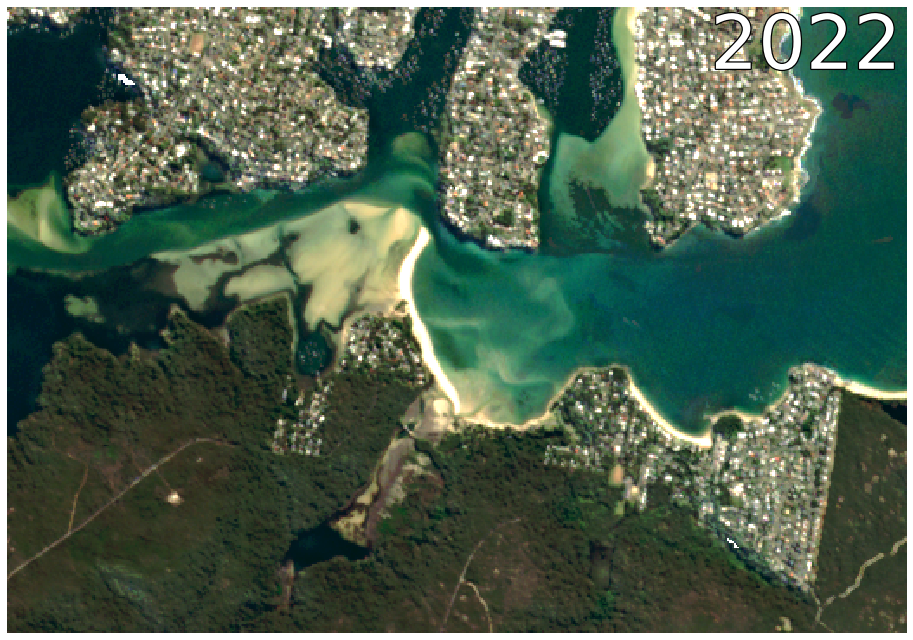

In [46]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

funcs_list = [
              # Apply `match_histograms` to reduce scene-to-scene variability
              lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
#     
              # Apply power transform to reduce bright highlights  
              lambda x: x**0.7,
    
              # Rescale values to range accepted by `xr_animation`
              rescale_intensity,
    
              # Apply different levels of unsharp masking to enhance
              # overall dynamic range, and improve fine scale detail
#               lambda x: unsharp_mask(x, radius=20, amount=0.3),
              lambda x: unsharp_mask(x, radius=5, amount=0.1),
              
              # # Contrast enhancement using sigmoid transform
              # lambda x: adjust_sigmoid(image=x, cutoff=0.7, gain=3)
             ]
# funcs_list = None

xr_animation(output_path='animation_timeseries_porthacking_s2.mp4',
             ds=ds_rolling.isel(time=slice(20, None)),
             show_text='',
             bands=bands[0:3],
             interval=40,
             width_pixels=900,
#              show_gdf=stradbroke,
#              gdf_kwargs={'color': 'None', 'edgecolor': 'red'},
             percentile_stretch=(0.007, 0.987),
             image_proc_funcs=funcs_list,
             show_date='%Y',
             annotation_kwargs={'fontsize': 75},
#              imshow_kwargs={'vmin': 0, 'vmax': 0.5},
#              limit=100,
            ) 

In [134]:
import geopandas as gpd

# out = gpd.read_file('https://satpathsapi.nemo.ga.gov.au/passes?satellites=40697&start=2021-09-15T00:00:00&end=2021-09-16T23:59:00&order=desc&format=json')
stradbroke = gpd.read_file('stradbroke.geojson')

In [ ]:
out.plot()

## Specialised animations

### DEA CoastLines animations

/tmp/ipykernel_4171/3715490915.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('inferno')


<Axes: >

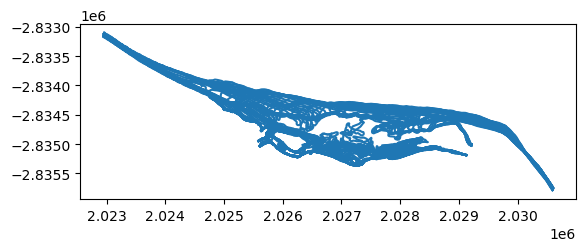

In [38]:
import geopandas as gpd
import pandas as pd
import matplotlib
from shapely.geometry import box, Point

# Get bounding box of data
xmin, ymin, xmax, ymax = ds.geobox.geographic_extent.boundingbox

bounds = [xmin, ymin, xmax, ymax]
bbox = gpd.GeoDataFrame(geometry=[box(*bounds)], 
                        crs='EPSG:4326')

# Set up WFS requests for annual coastlines & rates of change statistics
deacl_coastlines_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:shorelines_annual&maxFeatures=1000&' \
                      f'bbox={ymin},{xmin},{ymax},{xmax},urn:ogc:def:crs:EPSG:4326'

# # Load data from WFS and set CRS
deacl_gdf = gpd.read_file(deacl_coastlines_wfs)
# deacl_gdf = gpd.read_file('/g/data/r78/DEACoastlines/DEACoastlines_annualcoastlines_v1.1.4.shp', bbox=bbox)
deacl_gdf.crs = 'EPSG:3577'

# Clip to extent of satellite data
bbox = gpd.GeoDataFrame(geometry=[ds.geobox.extent.geom],
                        crs=ds.geobox.crs)  
deacl_gdf = gpd.overlay(deacl_gdf, bbox.to_crs(deacl_gdf.crs))
deacl_gdf = deacl_gdf.dissolve('year')

# Apply colours
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(deacl_gdf.index))
cmap = matplotlib.cm.get_cmap('inferno')
rgba = cmap(norm(deacl_gdf.reset_index().index))
deacl_gdf['color'] = list(rgba)
deacl_gdf['start_time'] = (pd.to_datetime(deacl_gdf.index.astype(int), format="%Y") + pd.DateOffset(months=6))

# # Remove a year
# # deacl_gdf = deacl_gdf.drop('1993')

deacl_gdf.plot()

In [ ]:
# minx, miny, maxx, maxy = deacl_gdf.unary_union.bounds
# from shapely.geometry import box
# import geopandas as gpd
# test = box(minx, -3570200, maxx, maxy)
# deacl_gdf = gpd.clip(deacl_gdf, gpd.GeoSeries(test, crs='EPSG:3577')) 
# deacl_gdf.plot()

Applying custom image processing functions


  0%|          | 0/35 (0.0 seconds remaining at ? frames/s)

Exporting animation to deacoastlines_annual_barubbra2.mp4


  0%|          | 0/35 (0.0 seconds remaining at ? frames/s)

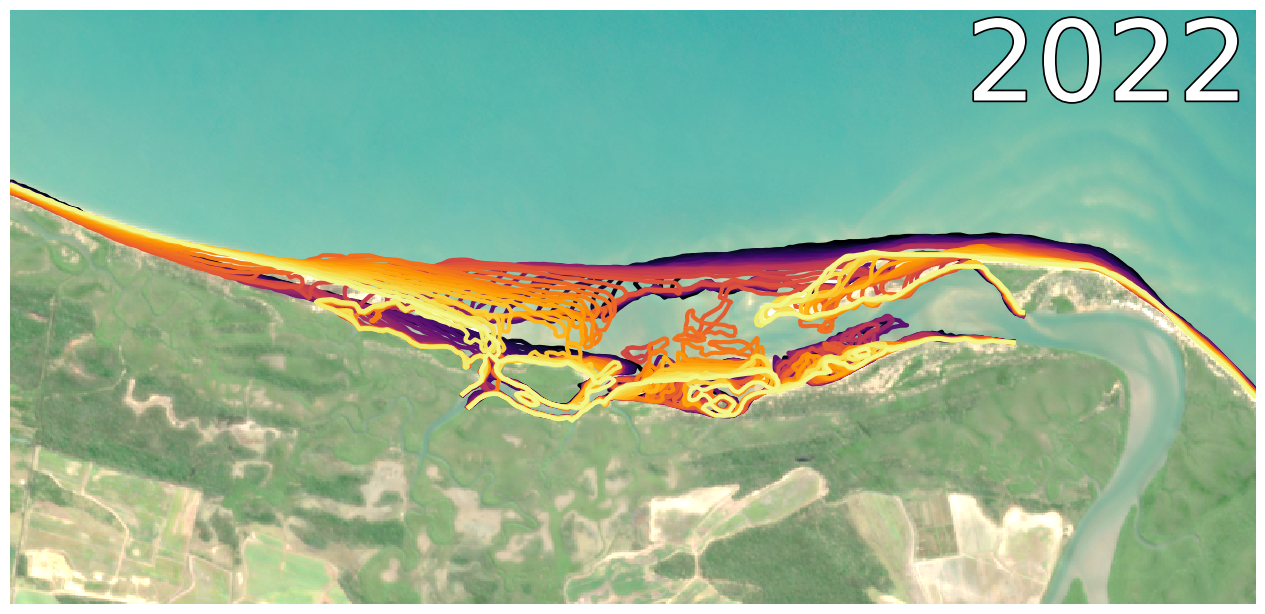

In [51]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

funcs_list = [# lambda x: match_histograms(image=x, reference=median_array, channel_axis=True),
              rescale_intensity,
#               hue_sat_val,
              # lambda x: unsharp_mask(x, radius=20, amount=0.2),
              # lambda x: unsharp_mask(x, radius=5, amount=0.2),
              lambda x: x**0.5,
#               lambda x: adjust_sigmoid(image=x, cutoff=0.7, gain=3)
             ]
# funcs_list = None

xr_animation(output_path='deacoastlines_annual_barubbra2.mp4',
             ds=ds_rolling.isel(time=slice(0, -1)),
             show_text="",
             bands=bands,
             interval=100,
             width_pixels=900,
             percentile_stretch=(0.05, 0.999),
             image_proc_funcs=funcs_list,
             show_date='%Y',
             annotation_kwargs={'fontsize': 80},
             show_gdf=deacl_gdf,
             gdf_kwargs = {'linewidth': 3},
#              imshow_kwargs={'vmin': -0.5, 'vmax': 0.7},   # Stuart Point, Twilight Bay
             imshow_kwargs={'vmin': -0.1, 'vmax': 0.6},
             # limit=3,
            ) 

In [47]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

funcs_list = [
              lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
              lambda x: x**0.8,
              rescale_intensity,
#               hue_sat_val,
              lambda x: unsharp_mask(x, radius=20, amount=0.2),
              lambda x: unsharp_mask(x, radius=5, amount=0.1),
#               lambda x: adjust_sigmoid(image=x, cutoff=0.7, gain=3)
             ]
# funcs_list = None

xr_animation(output_path='animation_sydney.mp4',
             ds=ds_rolling,  #.isel(time=slice(1, -1)),
             show_text='',
             bands=bands,
             interval=50,
             width_pixels=900,
             percentile_stretch=(0.01, 0.99),
             image_proc_funcs=funcs_list,
             show_date='%Y',
             annotation_kwargs={'fontsize': 60},
             show_gdf=deacl_gdf,
             gdf_kwargs = {'linewidth': 2.5},
#              imshow_kwargs={'vmin': -0.5, 'vmax': 0.7},   # Stuart Point, Twilight Bay
#              imshow_kwargs={'vmin': -0.2, 'vmax': 0.6},
#              limit=10,
            ) 

In [55]:
site='barubbra2'
!ffmpeg -y -i deacoastlines_annual_{site}.mp4 -i deacoastlines_inset_{site}.png \
-filter_complex "[0:v][1:v] overlay=0:0:enable='between(t,0,20)'" \
-pix_fmt yuv420p -c:a copy \
temp.mp4

!ffmpeg -y -i temp.mp4 -filter_complex "[0]trim=0:2[hold],[0][hold]concat[extended],[extended][0]overlay" -pix_fmt yuv420p -c:a copy deacoastlines_annualwithinset_{site}.mp4

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/env --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-vaapi --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib -

In [ ]:
!ffmpeg -y -i 'Landsat 5 7 8 - 1987-2019 - Corner Inlet - True colour animation.mp4' -i seminar_title.png \
-filter_complex "[0:v][1:v] overlay=0:0:enable='between(t,0,20)'" \
-pix_fmt yuv420p -c:a copy \
seminar_with_title.mp4

### Animated fade

In [ ]:
import imageio
import numpy as np

from_array = imageio.imread('tides_fade/tides_low.png')
to_array = imageio.imread('tides_fade/tides_high.png')

framerate = 30
pause = 3500
frames = 20

stacked_from_to = np.stack([to_array, from_array], axis=3)

intervals = np.linspace(0, 1.0, frames + 1).tolist()
weights = intervals + intervals[::-1][1:-1]
milliseconds = [pause] + [framerate] * (len(intervals) - 2) + [pause] + [framerate] * (len(intervals) - 2)
# weights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
# milliseconds = [50, 50, 50, 50, 50, 50, 50, 50, 50, 3500, 50, 50, 50, 50, 50, 50, 50, 50, 50, 3500]

for i, weight in enumerate(weights):

    ave_from_to = np.average(stacked_from_to, axis=3, weights=np.array([weight, 1.0 - weight]))
    imageio.imwrite(f'tides_fade/output_{i}_({milliseconds[i]}ms).png', ave_from_to.astype(np.uint8))


### Mangrove animation

In [ ]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

ndvi = (d
        
        
        
        s_rolling["nbart_nir"] - ds_rolling["nbart_red"])/(ds_rolling["nbart_nir"] + ds_rolling["nbart_red"])
ds_rolling2 = ds_rolling * rescale_intensity(image=ndvi, in_range=(0, 0.8), out_range=(0, 1.0))



In [ ]:

funcs_list = [
#               lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
#               lambda x: x**0.8,
#               ndvi_mult,
              rescale_intensity,
#               hue_sat_val,
#               lambda x: unsharp_mask(x, radius=20, amount=0.2),
#               lambda x: unsharp_mask(x, radius=5, amount=0.1),
#               lambda x: adjust_sigmoid(image=x, cutoff=0.7, gain=3)
             ]
funcs_list = None

xr_animation(output_path='animation_bowling.mp4',
             ds=ds_rolling2.isel(time=slice(20, -10)),
             show_text='',
             bands=bands[0:3],
             interval=50,
             width_pixels=900,
             percentile_stretch=(0.001, 0.999),
             image_proc_funcs=funcs_list,
             show_date='%Y',
             annotation_kwargs={'fontsize': 60},
#              show_gdf=deacl_gdf,
#              gdf_kwargs = {'linewidth': 2.5},
#              imshow_kwargs={'vmin': -0.5, 'vmax': 0.7},   # Stuart Point, Twilight Bay
#              imshow_kwargs={'vmin': -0.2, 'vmax': 0.6},
#              limit=20,
            ) 